In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
import keras
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:

Emotions= pd.read_csv('/kaggle/input/emotion/emotion (1).csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,-258.990326,132.193741,5.314349,21.521330,-24.357752,-2.237025,-24.086287,-9.530801,-20.967497,-4.285268,...,-0.953883,1.146237,1.829600,2.893938,1.310414,1.626812,2.758013,4.257873,3.918041,male_happy
1,-258.667152,132.047682,5.236842,21.529129,-24.335813,-2.170860,-24.135509,-9.465332,-20.959675,-4.215839,...,-0.906946,1.140402,1.826270,2.867984,1.350153,1.576485,2.766849,4.228887,3.915566,male_happy
2,-301.181824,128.659897,4.380285,9.940308,-23.697367,-7.601327,-25.921268,-13.189119,-19.924520,-0.300373,...,3.321182,3.191138,3.419615,3.112536,1.654553,3.749860,5.546700,4.269989,1.401541,male_happy
3,-274.135437,142.405472,-2.322214,21.200804,-27.737436,-1.496183,-26.762552,-10.112954,-21.643480,-3.658734,...,-1.149690,1.346368,2.298612,3.353943,1.820001,2.129130,2.610373,4.910376,4.944275,male_happy
4,-274.135437,142.405472,-2.322214,21.200804,-27.737436,-1.496183,-26.762552,-10.112954,-21.643480,-3.658734,...,-1.149690,1.346368,2.298612,3.353943,1.820001,2.129130,2.610373,4.910376,4.944275,male_happy


In [3]:
X = Emotions.drop('labels',axis = 1)
Y = Emotions['labels']

In [4]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [5]:
# since it is a multiclass classifier, i will perform onehotencoding
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [6]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,shuffle = True)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((48648, 40), (48648, 14), (12162, 40), (12162, 14))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((48648, 40), (48648, 14), (12162, 40), (12162, 14))

# CNN

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D,Dense,AveragePooling1D,Dropout,add,BatchNormalization,LSTM,Flatten,MaxPooling1D,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from keras.activations import relu, softmax
from sklearn.metrics import confusion_matrix,classification_report

In [9]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((48648, 40, 1), (48648, 14), (12162, 40, 1), (12162, 14))

In [10]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Flatten, Reshape, Multiply, Add

# input layer
inputs = Input(shape=(x_train.shape[1], 1))

# 1st Conv1D layer with residual connection
conv1 = Conv1D(256, kernel_size=7, strides=1, padding='same', activation='relu')(inputs)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn1)

res1 = Conv1D(128, kernel_size=1, strides=1, padding='same')(pool1)

# 2nd Conv1D layer with residual connection and attention mechanism
conv2 = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(pool1)
bn2 = BatchNormalization()(conv2)
pool2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn2)

res2 = Conv1D(128, kernel_size=1, strides=1, padding='same')(pool2)

attention = Dense(1, activation='tanh')(pool2)
attention = Flatten()(attention)
attention = Dense(pool2.shape[1], activation='softmax')(attention)
attention = Reshape((pool2.shape[1], 1))(attention)
attention = Multiply()([pool2, attention])

# 3rd Conv1D layer with residual connection and dropout
conv3 = Conv1D(64, kernel_size=7, strides=1, padding='same', activation='relu')(attention)
bn3 = BatchNormalization()(conv3)
pool3 = MaxPooling1D(pool_size=2, strides=2, padding='same')(bn3)

res3 = Conv1D(64, kernel_size=1, strides=1, padding='same')(pool3)

dropout = Dropout(0.5)(pool3)

# flatten and dense layers
flatten = Flatten()(dropout)
dense1 = Dense(units=32, activation='relu')(flatten)
dropout2 = Dropout(0.5)(dense1)

# output layer
outputs = Dense(units=14, activation='softmax')(dropout2)

# create the model
my_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# compile the model
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 40, 256)      2048        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 40, 256)     1024        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 20, 256)      0           ['batch_normalization[0][0]']

In [11]:
history = my_model.fit(x_traincnn, y_train, batch_size=32, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
1521/1521 [==============================] - 23s 9ms/step - loss: 2.0894 - accuracy: 0.3001 - val_loss: 1.5165 - val_accuracy: 0.4663
Epoch 2/100
1521/1521 [==============================] - 12s 8ms/step - loss: 1.6044 - accuracy: 0.4269 - val_loss: 1.3315 - val_accuracy: 0.5191
Epoch 3/100
1521/1521 [==============================] - 13s 8ms/step - loss: 1.4617 - accuracy: 0.4675 - val_loss: 1.2422 - val_accuracy: 0.5302
Epoch 4/100
1521/1521 [==============================] - 12s 8ms/step - loss: 1.3811 - accuracy: 0.4892 - val_loss: 1.1887 - val_accuracy: 0.5531
Epoch 5/100
1521/1521 [==============================] - 12s 8ms/step - loss: 1.3352 - accuracy: 0.5025 - val_loss: 1.1318 - val_accuracy: 0.5685
Epoch 6/100
1521/1521 [==============================] - 14s 9ms/step - loss: 1.2870 - accuracy: 0.5214 - val_loss: 1.1061 - val_accuracy: 0.5787
Epoch 7/100
1521/1521 [==============================] - 12s 8ms/step - loss: 1.2488 - accuracy: 0.5347 - val_loss: 1.0748 -

In [12]:
print("Accuracy of our model  : " , round(my_model.evaluate(x_testcnn,y_test)[1],2)*100 , "%")

381/381 [==============================] - 1s 4ms/step - loss: 0.6342 - accuracy: 0.7963
Accuracy of our model  :  80.0 %


In [13]:
model_name = 'emotion_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)   # adds file in folder
my_model.save(model_path)
print('Save model and weights at %s' % model_path)
model_json = my_model.to_json()
with open('model_json.json', 'w') as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/emotion_model.h5


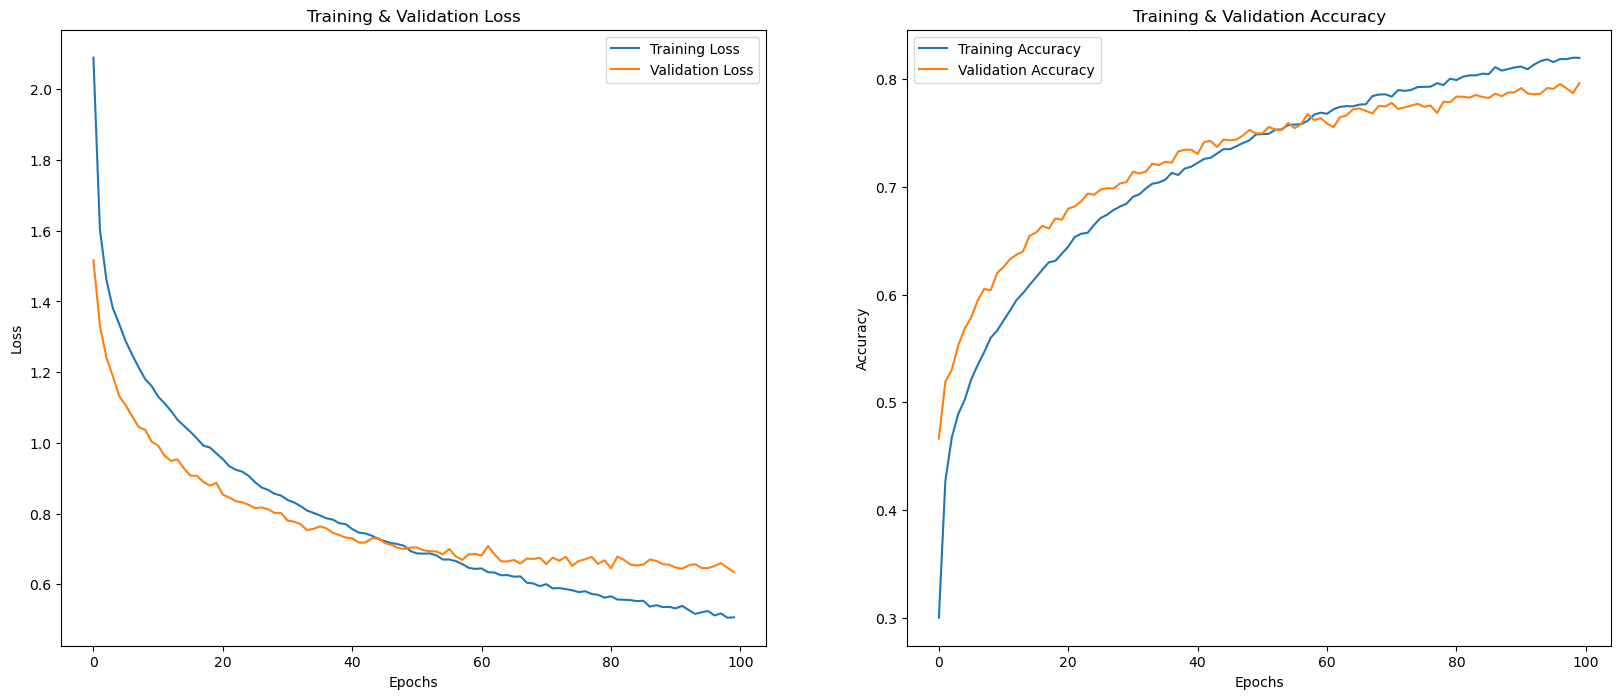

In [14]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,8)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [15]:
# predicting on test data.
pred_test = my_model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

381/381 [==============================] - 1s 3ms/step


In [16]:
df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
df['PredictedLabels'] = y_pred.flatten()
df['ActualLabels'] = y_test.flatten()

In [17]:
df

,PredictedLabels,ActualLabels
0,male_sad,male_sad
1,female_happy,female_happy
2,female_fear,female_fear
3,female_surprise,female_surprise
4,female_surprise,female_surprise
...,...,...
12157,female_angry,female_angry
12158,female_surprise,female_surprise
12159,female_angry,female_angry
12160,male_angry,female_angry


In [18]:
df.to_csv('Predictions.csv', index = False)

In [19]:
import seaborn as sns

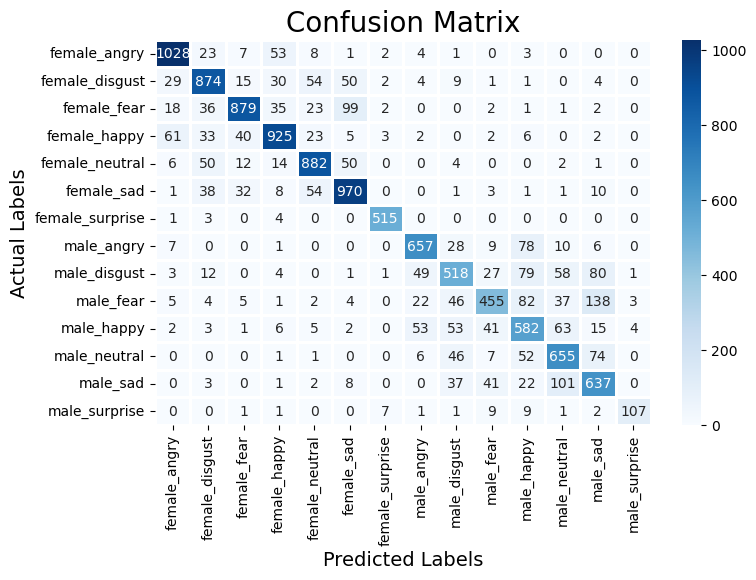

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8,5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.89      0.91      0.90      1130
 female_disgust       0.81      0.81      0.81      1073
    female_fear       0.89      0.80      0.84      1098
   female_happy       0.85      0.84      0.85      1102
 female_neutral       0.84      0.86      0.85      1021
     female_sad       0.82      0.87      0.84      1119
female_surprise       0.97      0.98      0.98       523
     male_angry       0.82      0.83      0.82       796
   male_disgust       0.70      0.62      0.66       833
      male_fear       0.76      0.57      0.65       804
     male_happy       0.64      0.70      0.67       830
   male_neutral       0.71      0.78      0.74       842
       male_sad       0.66      0.75      0.70       852
  male_surprise       0.93      0.77      0.84       139

       accuracy                           0.80     12162
      macro avg       0.80      0.79      0.80     12162
   weighted avg       0.80   

# Emotion accuracy

In [22]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.ActualLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [23]:
modidf['predictedvalues'] = modidf.PredictedLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 
# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))

0.8027462588390067


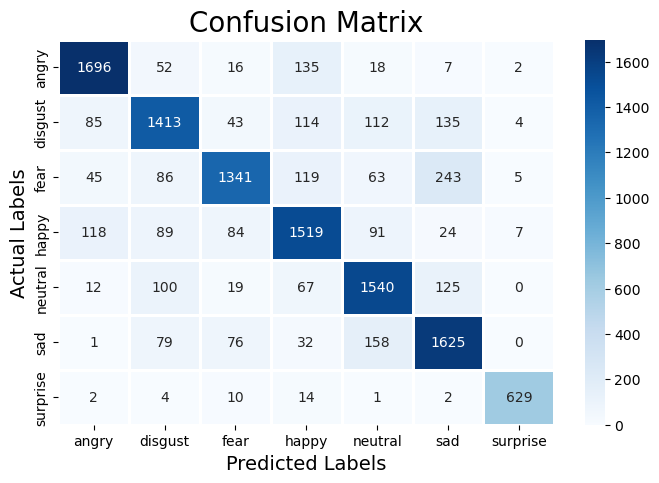

In [24]:
cm = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
plt.figure(figsize = (8,5))
x= pd.DataFrame(cm,  columns=(classes), index=(classes))
sns.heatmap(x, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification report

In [25]:
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.87      0.88      0.87      1926
     disgust       0.78      0.74      0.76      1906
        fear       0.84      0.71      0.77      1902
       happy       0.76      0.79      0.77      1932
     neutral       0.78      0.83      0.80      1863
         sad       0.75      0.82      0.79      1971
    surprise       0.97      0.95      0.96       662

    accuracy                           0.80     12162
   macro avg       0.82      0.82      0.82     12162
weighted avg       0.80      0.80      0.80     12162

